In [1]:
from typing import List, Optional, Callable, Iterable
from itertools import islice
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from gluonts.dataset.repository import get_dataset

/Users/adriencortes/Documents/13- Articles/7- TimeGrad/pytorch-ts-master/pytorchts/lib/python3.9/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
dataset = get_dataset("electricity")

/Users/adriencortes/Documents/13- Articles/7- TimeGrad/pytorch-ts-master/pytorchts/lib/python3.9/site-packages/gluonts/dataset/repository/_lstnet.py:133: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.period_range(


/Users/adriencortes/Documents/13- Articles/7- TimeGrad/pytorch-ts-master/pytorchts/lib/python3.9/site-packages/gluonts/dataset/common.py:263: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.Period(val, freq)
/var/folders/jb/8bmzmwqn3h14s2z9jr4gfg880000gn/T/ipykernel_21072/1467569442.py:12: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  plt.xticks(pd.date_range(start="2011-12-31", periods=3, freq="AS"))


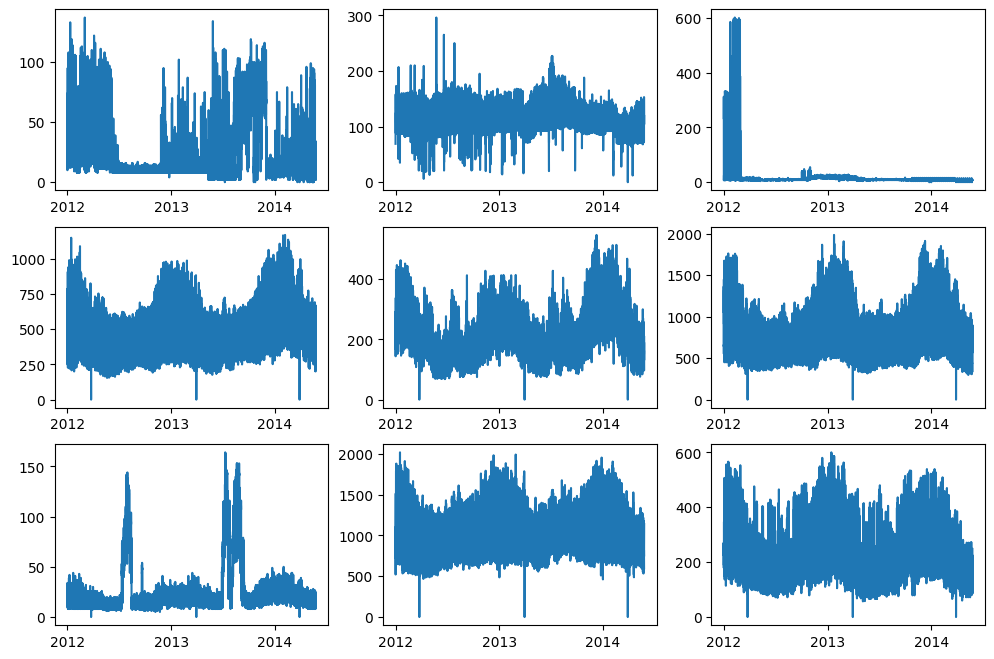

In [3]:
date_formater = mdates.DateFormatter("%Y")

fig = plt.figure(figsize=(12, 8))
for idx, entry in enumerate(islice(dataset.train, 9)):
    ax = plt.subplot(3, 3, idx + 1)
    t = pd.date_range(
        start=entry["start"].to_timestamp(),
        periods=len(entry["target"]),
        freq=entry["start"].freq,
    )
    plt.plot(t, entry["target"])
    plt.xticks(pd.date_range(start="2011-12-31", periods=3, freq="AS"))
    ax.xaxis.set_major_formatter(date_formater)

In [4]:
import torch
import torch.nn as nn
from gluonts.torch.model.predictor import PyTorchPredictor
from gluonts.torch.distributions import StudentTOutput
from gluonts.model.forecast_generator import DistributionForecastGenerator
def mean_abs_scaling(context, min_scale=1e-5):
    return context.abs().mean(1).clamp(min_scale, None).unsqueeze(1)